### Imports

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import cv2 as cv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET = 'brats'
IMG_SIZE = (32, 32) if DATASET in ['mnist', 'cifar10'] else (128, 128)
IN_CHANNELS = 2
EPOCHS = 5000
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
T = 700

assert DATASET in ['mnist', 'cifar10', 'brats']
print('imported: ', DATASET, IMG_SIZE, IN_CHANNELS, EPOCHS, BATCH_SIZE, LEARNING_RATE, T)

imported:  brats (128, 128) 2 5000 8 0.0001 700


### Data preprocessing

Train iteration: 62


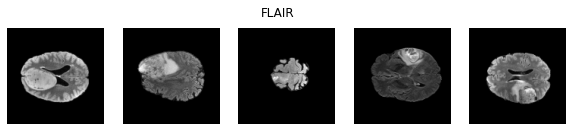

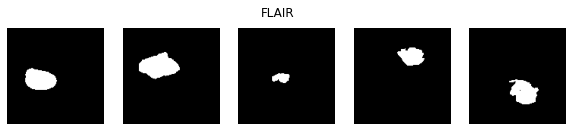

In [2]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx]), self.y[idx]
        return self.x[idx], self.y[idx]

def resize_binary_mask(mask, size):
    mask_tensor = torch.from_numpy(mask).float()
    resized_mask_tensor = TF.resize(mask_tensor, size, interpolation=TF.InterpolationMode.NEAREST)
    resized_mask = resized_mask_tensor.numpy()
    resized_mask = (resized_mask > 0.5).astype(np.uint8)
    return resized_mask

# loading data
# data = np.load('./data/seg_train_data.npy')
data = np.load('../riemannian_variational_autoencoder/data/brats_data.npz')
flair, t1ce, mask = data['flair'], data['t1ce'], data['mask']



# images, masks = data[:, 0, None], data[:, 1]
# images = TF.resize(torch.from_numpy(images).float(), IMG_SIZE, antialias=True)
# images = (images - 0.5) * 2
# masks = resize_binary_mask(masks, IMG_SIZE)
# masks = masks[:, None]

# train_dataset = IdentityDataset(images, masks)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

# batch = next(iter(train_loader))[:BATCH_SIZE]
# print('Train iteration:', len(train_loader))
    
# n_sample = 5 if BATCH_SIZE > 5 else BATCH_SIZE

# for i in range(2):
#     plt.figure(figsize=(10, 2))
#     for j in range(n_sample):
#         plt.subplot(1, n_sample, j + 1)
#         plt.imshow(batch[i][j, 0].numpy(), cmap='gray')
#         plt.axis('off')
#     plt.suptitle('FLAIR' if 0 == 0 else 'MASK')
#     plt.show()

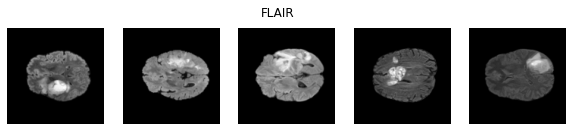

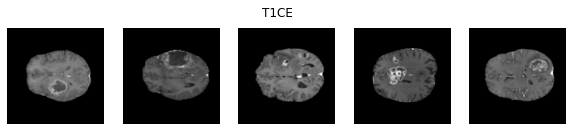

Number of training samples: 500
Image size: torch.Size([128, 128])
Total shape: torch.Size([500, 2, 128, 128])
Max pixel value: 0.9864888191223145
Min pixel value: -1.0


In [41]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx]), self.y[idx]
        return self.x[idx], self.y[idx]

# loading brats dataset
data = np.load('../riemannian_variational_autoencoder/data/brats_data.npz')
flair, t1ce, mask = data['flair'], data['t1ce'], data['mask']


# preprocessing
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1ce = [t1ce[i].max() for i in range(t1ce.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1ce[idx] = (t1ce[idx] / n_max_t1ce[idx]).astype(np.float32)

flair = flair * 2 - 1
t1ce = t1ce * 2 - 1

n_sample = 500
flair = torch.from_numpy(flair)[:n_sample, None]
t1ce = torch.from_numpy(t1ce)[:n_sample, None]
mask = torch.from_numpy(mask)[:n_sample, None]

mask[mask > 0] = 1 # binarizing mask

# resize images
if IMG_SIZE != flair.shape[2:]:
    flair = TF.resize(flair, IMG_SIZE, antialias=True)
    t1ce = TF.resize(t1ce, IMG_SIZE, antialias=True)
    mask = TF.resize(mask, IMG_SIZE, antialias=True)

mask = mask.round().type(torch.long)
train_x = torch.cat([flair, t1ce], dim=1).type(torch.float32)
train_x.clip_(-1, 1)

train_dataset = IdentityDataset(train_x, mask)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, train_x.shape[0], n_to_visualize)

for j in range(2):
    plt.figure(figsize=(10, 2))
    for i in range(n_to_visualize):
        plt.subplot(1, n_to_visualize, i + 1)
        plt.imshow(train_x[rand_idx[i], j], cmap='gray')
        plt.axis('off')
    plt.suptitle('FLAIR' if j == 0 else 'T1CE')
    plt.show()

print('Number of training samples: {}'.format(train_x.shape[0]))
print('Image size: {}'.format(train_x.shape[2:]))
print('Total shape: {}'.format(train_x.shape))
print('Max pixel value: {}'.format(train_x.max()))
print('Min pixel value: {}'.format(train_x.min()))

In [ ]:
n_sample = 15000
if DATASET == 'mnist':
    data = MNIST(root='data', train=True, download=True, transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ]))
    data = torch.utils.data.Subset(data, np.random.choice(len(data), n_sample, replace=False))
elif DATASET == 'cifar10':
    data = CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
    data = torch.utils.data.Subset(data, np.random.choice(len(data), n_sample, replace=False))

train_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True, drop_last=True)

print('Train iteration:', len(train_loader))
print('Train data:', len(data))

batch = next(iter(train_loader))
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0][i].permute(1, 2, 0), cmap='gray' if DATASET == 'mnist' else None)
    plt.axis('off')
plt.show()

## EMA

In [39]:
class EMA():
    def __init__(self, decay):
        self.decay = decay
    
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.decay + (1 - self.decay) * new

    def update_model_average(self, ema_model, current_model):
        for current_params, ema_params in zip(current_model.parameters(), ema_model.parameters()):
            old, new = ema_params.data, current_params.data
            ema_params.data = self.update_average(old, new)

## Training DDPM

Epoch: 12/5000 | Loss: 0.0218: 100%|██████████| 62/62 [00:15<00:00,  3.96it/s]
Epoch: 1/5000 | Loss: 0.0221: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 2/5000 | Loss: 0.0249: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 3/5000 | Loss: 0.0214: 100%|██████████| 62/62 [00:08<00:00,  7.42it/s]
Epoch: 4/5000 | Loss: 0.0201: 100%|██████████| 62/62 [00:08<00:00,  7.47it/s]
Epoch: 5/5000 | Loss: 0.0177: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 6/5000 | Loss: 0.0216: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]
Epoch: 7/5000 | Loss: 0.0200: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 8/5000 | Loss: 0.0201: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 9/5000 | Loss: 0.0187: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 10/5000 | Loss: 0.0183: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 11/5000 | Loss: 0.0204: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
Epoch: 12/5000 | Loss: 0.0216: 100%|██████████| 62/62 [00:08<

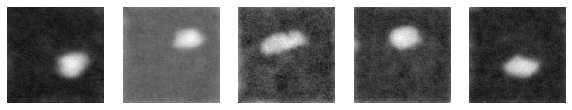

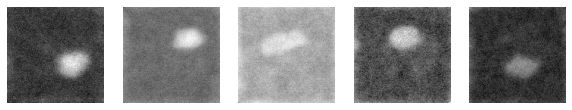

Epoch: 200/5000 | Loss: 0.0089: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]
Epoch: 201/5000 | Loss: 0.0100: 100%|██████████| 62/62 [00:09<00:00,  6.41it/s]
Epoch: 202/5000 | Loss: 0.0083: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]
Epoch: 203/5000 | Loss: 0.0096: 100%|██████████| 62/62 [00:09<00:00,  6.71it/s]
Epoch: 204/5000 | Loss: 0.0134: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]
Epoch: 205/5000 | Loss: 0.0100: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]
Epoch: 206/5000 | Loss: 0.0118: 100%|██████████| 62/62 [00:09<00:00,  6.26it/s]
Epoch: 207/5000 | Loss: 0.0100: 100%|██████████| 62/62 [00:09<00:00,  6.63it/s]
Epoch: 208/5000 | Loss: 0.0098: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]
Epoch: 209/5000 | Loss: 0.0089: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]
Epoch: 210/5000 | Loss: 0.0090: 100%|██████████| 62/62 [00:09<00:00,  6.61it/s]
Epoch: 211/5000 | Loss: 0.0099: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]
Epoch: 212/5000 | Loss: 0.0110: 100%|███

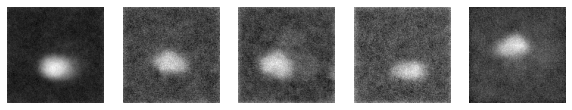

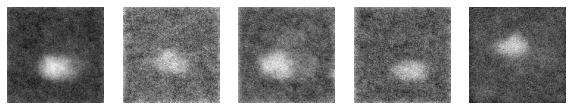

Epoch: 400/5000 | Loss: 0.0073: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]
Epoch: 401/5000 | Loss: 0.0070: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]
Epoch: 402/5000 | Loss: 0.0069: 100%|██████████| 62/62 [00:09<00:00,  6.57it/s]
Epoch: 403/5000 | Loss: 0.0056: 100%|██████████| 62/62 [00:09<00:00,  6.72it/s]
Epoch: 404/5000 | Loss: 0.0064: 100%|██████████| 62/62 [00:09<00:00,  6.59it/s]
Epoch: 405/5000 | Loss: 0.0045: 100%|██████████| 62/62 [00:09<00:00,  6.55it/s]
Epoch: 406/5000 | Loss: 0.0060: 100%|██████████| 62/62 [00:09<00:00,  6.67it/s]
Epoch: 407/5000 | Loss: 0.0076: 100%|██████████| 62/62 [00:09<00:00,  6.66it/s]
Epoch: 408/5000 | Loss: 0.0056: 100%|██████████| 62/62 [00:09<00:00,  6.53it/s]
Epoch: 409/5000 | Loss: 0.0062: 100%|██████████| 62/62 [00:09<00:00,  6.63it/s]
Epoch: 410/5000 | Loss: 0.0060: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]
Epoch: 411/5000 | Loss: 0.0074: 100%|██████████| 62/62 [00:09<00:00,  6.66it/s]
Epoch: 412/5000 | Loss: 0.0061: 100%|███

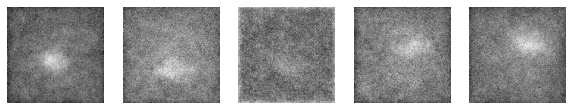

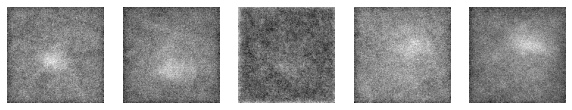

Epoch: 600/5000 | Loss: 0.0040: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]
Epoch: 601/5000 | Loss: 0.0049: 100%|██████████| 62/62 [00:09<00:00,  6.54it/s]
Epoch: 602/5000 | Loss: 0.0063: 100%|██████████| 62/62 [00:09<00:00,  6.61it/s]
Epoch: 603/5000 | Loss: 0.0070: 100%|██████████| 62/62 [00:09<00:00,  6.55it/s]
Epoch: 604/5000 | Loss: 0.0075: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]
Epoch: 605/5000 | Loss: 0.0054: 100%|██████████| 62/62 [00:09<00:00,  6.71it/s]
Epoch: 606/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:09<00:00,  6.76it/s]
Epoch: 607/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:09<00:00,  6.73it/s]
Epoch: 608/5000 | Loss: 0.0044: 100%|██████████| 62/62 [00:09<00:00,  6.78it/s]
Epoch: 609/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:09<00:00,  6.76it/s]
Epoch: 610/5000 | Loss: 0.0067: 100%|██████████| 62/62 [00:09<00:00,  6.56it/s]
Epoch: 611/5000 | Loss: 0.0037: 100%|██████████| 62/62 [00:09<00:00,  6.71it/s]
Epoch: 612/5000 | Loss: 0.0071: 100%|███

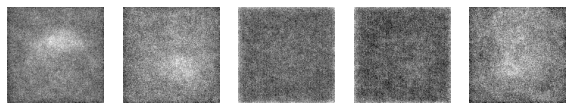

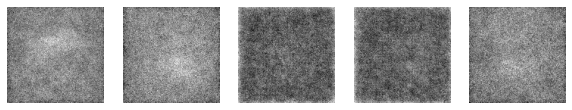

Epoch: 800/5000 | Loss: 0.0045: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 801/5000 | Loss: 0.0044: 100%|██████████| 62/62 [00:09<00:00,  6.78it/s]
Epoch: 802/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:09<00:00,  6.69it/s]
Epoch: 803/5000 | Loss: 0.0056: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]
Epoch: 804/5000 | Loss: 0.0058: 100%|██████████| 62/62 [00:09<00:00,  6.77it/s]
Epoch: 805/5000 | Loss: 0.0048: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]
Epoch: 806/5000 | Loss: 0.0050: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]
Epoch: 807/5000 | Loss: 0.0044: 100%|██████████| 62/62 [00:09<00:00,  6.80it/s]
Epoch: 808/5000 | Loss: 0.0059: 100%|██████████| 62/62 [00:09<00:00,  6.73it/s]
Epoch: 809/5000 | Loss: 0.0061: 100%|██████████| 62/62 [00:09<00:00,  6.69it/s]
Epoch: 810/5000 | Loss: 0.0038: 100%|██████████| 62/62 [00:09<00:00,  6.44it/s]
Epoch: 811/5000 | Loss: 0.0033: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]
Epoch: 812/5000 | Loss: 0.0047: 100%|███

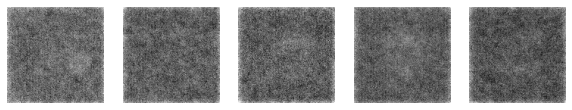

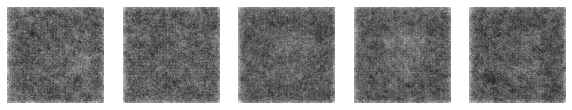

Epoch: 1000/5000 | Loss: 0.0049: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]
Epoch: 1001/5000 | Loss: 0.0056: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 1002/5000 | Loss: 0.0058: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 1003/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:08<00:00,  7.37it/s]
Epoch: 1004/5000 | Loss: 0.0070: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
Epoch: 1005/5000 | Loss: 0.0036: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 1006/5000 | Loss: 0.0037: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 1007/5000 | Loss: 0.0040: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 1008/5000 | Loss: 0.0048: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 1009/5000 | Loss: 0.0042: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 1010/5000 | Loss: 0.0046: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
Epoch: 1011/5000 | Loss: 0.0057: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 1012/5000 | Loss: 0.0

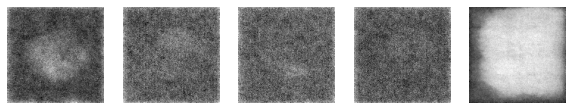

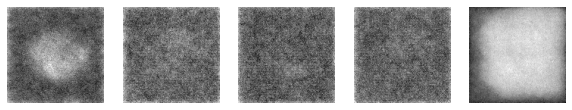

Epoch: 1200/5000 | Loss: 0.0040: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]
Epoch: 1201/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 1202/5000 | Loss: 0.0043: 100%|██████████| 62/62 [00:08<00:00,  6.99it/s]
Epoch: 1203/5000 | Loss: 0.0038: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
Epoch: 1204/5000 | Loss: 0.0043: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 1205/5000 | Loss: 0.0051: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 1206/5000 | Loss: 0.0059: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 1207/5000 | Loss: 0.0034: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
Epoch: 1208/5000 | Loss: 0.0046: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 1209/5000 | Loss: 0.0038: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 1210/5000 | Loss: 0.0049: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 1211/5000 | Loss: 0.0028: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 1212/5000 | Loss: 0.0

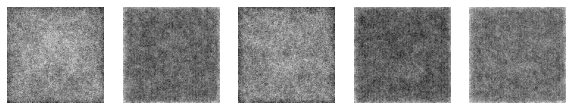

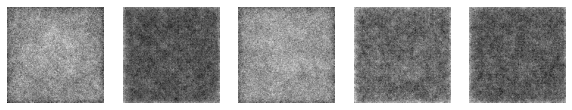

Epoch: 1400/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]
Epoch: 1401/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 1402/5000 | Loss: 0.0027: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 1403/5000 | Loss: 0.0038: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 1404/5000 | Loss: 0.0027: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 1405/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 1406/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 1407/5000 | Loss: 0.0042: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 1408/5000 | Loss: 0.0062: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 1409/5000 | Loss: 0.0053: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 1410/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]
Epoch: 1411/5000 | Loss: 0.0034: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]
Epoch: 1412/5000 | Loss: 0.0

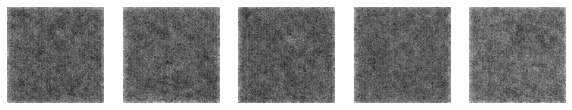

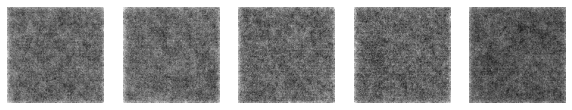

Epoch: 1600/5000 | Loss: 0.0031: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 1601/5000 | Loss: 0.0034: 100%|██████████| 62/62 [00:08<00:00,  7.03it/s]
Epoch: 1602/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.06it/s]
Epoch: 1603/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 1604/5000 | Loss: 0.0037: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 1605/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 1606/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 1607/5000 | Loss: 0.0029: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 1608/5000 | Loss: 0.0028: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]
Epoch: 1609/5000 | Loss: 0.0039: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
Epoch: 1610/5000 | Loss: 0.0029: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 1611/5000 | Loss: 0.0031: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 1612/5000 | Loss: 0.0

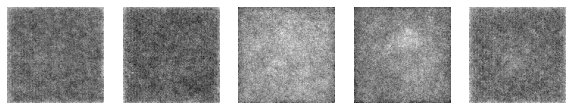

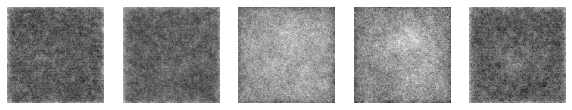

Epoch: 1800/5000 | Loss: 0.0047: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 1801/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 1802/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 1803/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 1804/5000 | Loss: 0.0025: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 1805/5000 | Loss: 0.0037: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 1806/5000 | Loss: 0.0037: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 1807/5000 | Loss: 0.0040: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 1808/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 1809/5000 | Loss: 0.0036: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 1810/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  6.95it/s]
Epoch: 1811/5000 | Loss: 0.0034: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 1812/5000 | Loss: 0.0

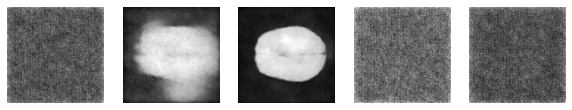

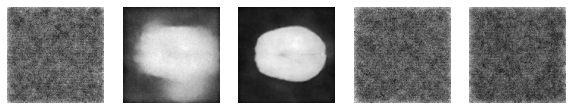

Epoch: 2000/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 2001/5000 | Loss: 0.0031: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 2002/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 2003/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 2004/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 2005/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:09<00:00,  6.77it/s]
Epoch: 2006/5000 | Loss: 0.0029: 100%|██████████| 62/62 [00:09<00:00,  6.84it/s]
Epoch: 2007/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2008/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 2009/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 2010/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 2011/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.12it/s]
Epoch: 2012/5000 | Loss: 0.0

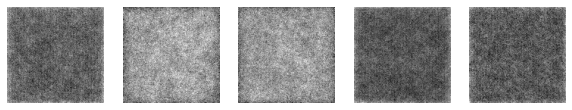

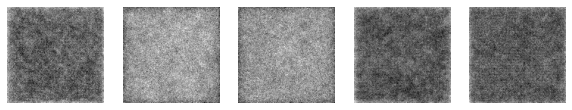

Epoch: 2200/5000 | Loss: 0.0028: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 2201/5000 | Loss: 0.0033: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 2202/5000 | Loss: 0.0027: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]
Epoch: 2203/5000 | Loss: 0.0033: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 2204/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]
Epoch: 2205/5000 | Loss: 0.0022: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
Epoch: 2206/5000 | Loss: 0.0025: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 2207/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 2208/5000 | Loss: 0.0015: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 2209/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 2210/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 2211/5000 | Loss: 0.0030: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 2212/5000 | Loss: 0.0

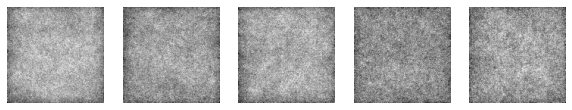

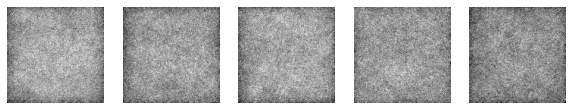

Epoch: 2400/5000 | Loss: 0.0034: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 2401/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 2402/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2403/5000 | Loss: 0.0032: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2404/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2405/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 2406/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 2407/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]
Epoch: 2408/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2409/5000 | Loss: 0.0023: 100%|██████████| 62/62 [00:08<00:00,  6.97it/s]
Epoch: 2410/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:08<00:00,  7.58it/s]
Epoch: 2411/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.63it/s]
Epoch: 2412/5000 | Loss: 0.0

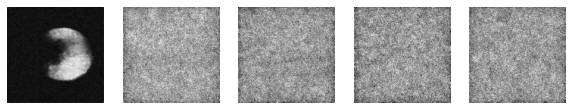

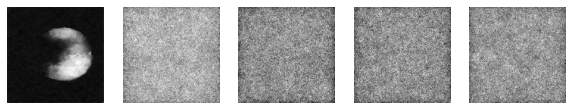

Epoch: 2600/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:49<00:00,  1.27it/s]
Epoch: 2601/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 2602/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  6.89it/s]
Epoch: 2603/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2604/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 2605/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
Epoch: 2606/5000 | Loss: 0.0028: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 2607/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 2608/5000 | Loss: 0.0027: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 2609/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 2610/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 2611/5000 | Loss: 0.0020: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 2612/5000 | Loss: 0.0

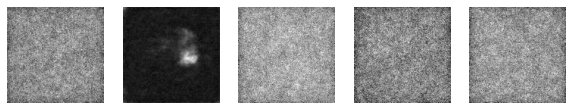

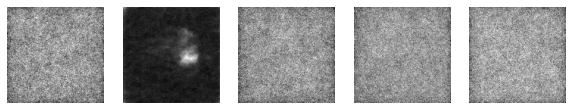

Epoch: 2800/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 2801/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 2802/5000 | Loss: 0.0024: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]
Epoch: 2803/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]
Epoch: 2804/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 2805/5000 | Loss: 0.0019: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]
Epoch: 2806/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.12it/s]
Epoch: 2807/5000 | Loss: 0.0026: 100%|██████████| 62/62 [00:08<00:00,  6.98it/s]
Epoch: 2808/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:09<00:00,  6.38it/s]
Epoch: 2809/5000 | Loss: 0.0021: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]
Epoch: 2810/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 2811/5000 | Loss: 0.0022: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 2812/5000 | Loss: 0.0

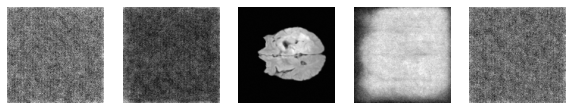

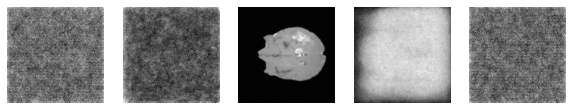

Epoch: 3000/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 3001/5000 | Loss: 0.0011: 100%|██████████| 62/62 [00:08<00:00,  7.02it/s]
Epoch: 3002/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 3003/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 3004/5000 | Loss: 0.0021: 100%|██████████| 62/62 [00:08<00:00,  7.03it/s]
Epoch: 3005/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 3006/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]
Epoch: 3007/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 3008/5000 | Loss: 0.0023: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 3009/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 3010/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 3011/5000 | Loss: 0.0015: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 3012/5000 | Loss: 0.0

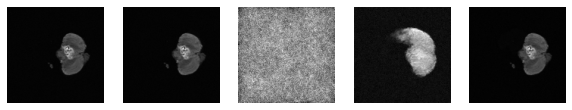

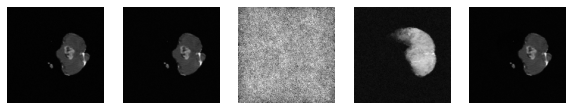

Epoch: 3200/5000 | Loss: 0.0015: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]
Epoch: 3201/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]
Epoch: 3202/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
Epoch: 3203/5000 | Loss: 0.0017: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 3204/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 3205/5000 | Loss: 0.0015: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 3206/5000 | Loss: 0.0011: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 3207/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 3208/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 3209/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.12it/s]
Epoch: 3210/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 3211/5000 | Loss: 0.0022: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 3212/5000 | Loss: 0.0

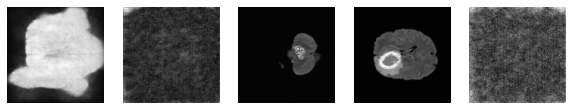

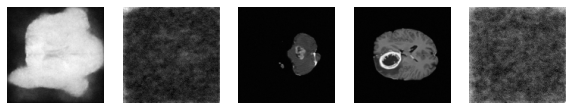

Epoch: 3400/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]
Epoch: 3401/5000 | Loss: 0.0015: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 3402/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 3403/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 3404/5000 | Loss: 0.0011: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]
Epoch: 3405/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  7.50it/s]
Epoch: 3406/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]
Epoch: 3407/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 3408/5000 | Loss: 0.0016: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]
Epoch: 3409/5000 | Loss: 0.0011: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 3410/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 3411/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
Epoch: 3412/5000 | Loss: 0.0

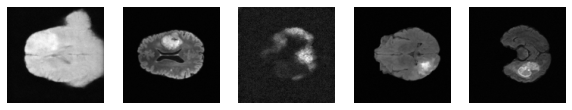

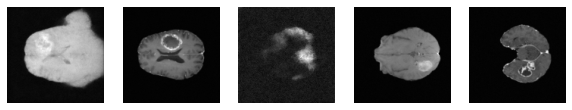

Epoch: 3600/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]
Epoch: 3601/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 3602/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  6.91it/s]
Epoch: 3603/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 3604/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 3605/5000 | Loss: 0.0018: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 3606/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 3607/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]
Epoch: 3608/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  6.97it/s]
Epoch: 3609/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]
Epoch: 3610/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 3611/5000 | Loss: 0.0014: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 3612/5000 | Loss: 0.0

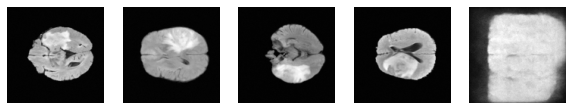

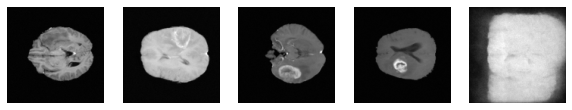

Epoch: 3800/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]
Epoch: 3801/5000 | Loss: 0.0011: 100%|██████████| 62/62 [00:08<00:00,  7.25it/s]
Epoch: 3802/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 3803/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
Epoch: 3804/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 3805/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 3806/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 3807/5000 | Loss: 0.0012: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 3808/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 3809/5000 | Loss: 0.0010: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]
Epoch: 3810/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 3811/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.04it/s]
Epoch: 3812/5000 | Loss: 0.0

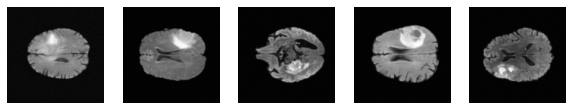

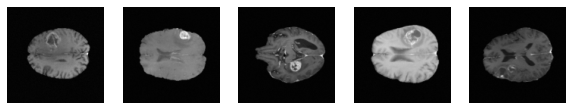

Epoch: 4000/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:49<00:00,  1.27it/s]
Epoch: 4001/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]
Epoch: 4002/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 4003/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 4004/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 4005/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]
Epoch: 4006/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 4007/5000 | Loss: 0.0013: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]
Epoch: 4008/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.49it/s]
Epoch: 4009/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]
Epoch: 4010/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s]
Epoch: 4011/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 4012/5000 | Loss: 0.0

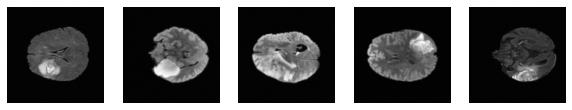

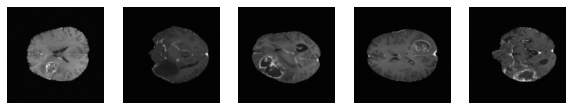

Epoch: 4200/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 4201/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]
Epoch: 4202/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 4203/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]
Epoch: 4204/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 4205/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:09<00:00,  6.32it/s]
Epoch: 4206/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:09<00:00,  6.48it/s]
Epoch: 4207/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]
Epoch: 4208/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:09<00:00,  6.69it/s]
Epoch: 4209/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:09<00:00,  6.55it/s]
Epoch: 4210/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:09<00:00,  6.66it/s]
Epoch: 4211/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]
Epoch: 4212/5000 | Loss: 0.0

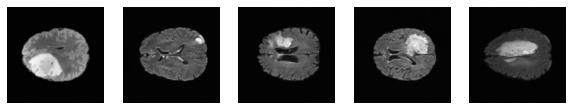

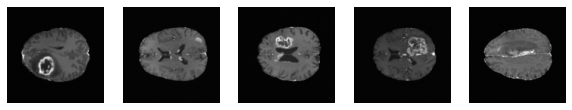

Epoch: 4400/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 4401/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 4402/5000 | Loss: 0.0003: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 4403/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.00it/s]
Epoch: 4404/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 4405/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 4406/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 4407/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]
Epoch: 4408/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
Epoch: 4409/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]
Epoch: 4410/5000 | Loss: 0.0008: 100%|██████████| 62/62 [00:08<00:00,  6.96it/s]
Epoch: 4411/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.06it/s]
Epoch: 4412/5000 | Loss: 0.0

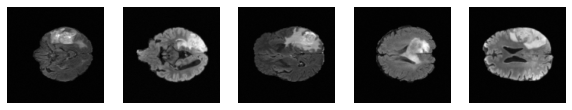

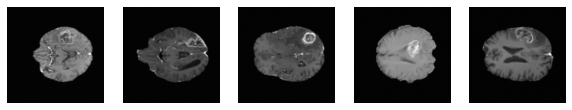

Epoch: 4600/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]
Epoch: 4601/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
Epoch: 4602/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]
Epoch: 4603/5000 | Loss: 0.0007: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]
Epoch: 4604/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]
Epoch: 4605/5000 | Loss: 0.0009: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 4606/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 4607/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]
Epoch: 4608/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 4609/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 4610/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]
Epoch: 4611/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 4612/5000 | Loss: 0.0

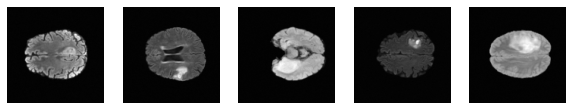

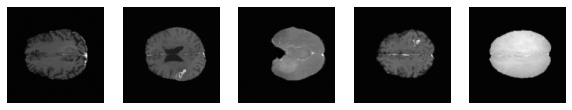

Epoch: 4800/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]
Epoch: 4801/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]
Epoch: 4802/5000 | Loss: 0.0003: 100%|██████████| 62/62 [00:08<00:00,  7.07it/s]
Epoch: 4803/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
Epoch: 4804/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 4805/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]
Epoch: 4806/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:09<00:00,  6.26it/s]
Epoch: 4807/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:09<00:00,  6.47it/s]
Epoch: 4808/5000 | Loss: 0.0004: 100%|██████████| 62/62 [00:08<00:00,  7.00it/s]
Epoch: 4809/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]
Epoch: 4810/5000 | Loss: 0.0005: 100%|██████████| 62/62 [00:08<00:00,  7.13it/s]
Epoch: 4811/5000 | Loss: 0.0006: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
Epoch: 4812/5000 | Loss: 0.0

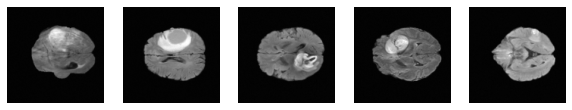

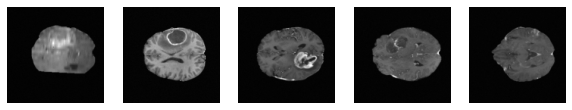

In [48]:
from models.ddpm import ResUNet, DiffusionModule

AMP = True
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

model = ResUNet(in_channels=IN_CHANNELS + 1, out_channels=IN_CHANNELS, T=T).to(device)
# model = torch.compile(model)

print('Model size: {:.2f} mo'.format((sum([p.numel() for p in model.parameters() if p.requires_grad]) * 4) / 1024 ** 2))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=train_loader.__len__() * EPOCHS, eta_min=1e-9, last_epoch=-1
)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)
diffusion = DiffusionModule(T=T, beta_schedule='cosine')
total_loss_history = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    accumulated_loss = []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, (images, masks) in enumerate(train_loader):
        B = images.shape[0]
        images = images.to(device, dtype=torch.float32, non_blocking=True)
        masks = masks.to(device, dtype=torch.float32, non_blocking=True)

        # sample at random timesteps
        times = torch.randint(low=0, high=T, size=(B,), dtype=torch.long, device=device)

        with torch.autocast(device.type, enabled=AMP):
            # sample noisy images
            x_t, noise = diffusion.forward_process(images, times)
            x_t = x_t.to(device, dtype=torch.float32)

            # forward pass
            x_t_pred = diffusion.reverse_process(model, x_t, times, masks, fill_value=0.1)
            loss = F.mse_loss(x_t_pred, noise)


        scaler.scale(loss).backward()
        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            accumulated_loss.append(loss.item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                progress.set_description(f"Epoch: {epoch + 1}/{EPOCHS} | Loss: {np.mean(accumulated_loss):.4f}")

    total_loss_history.append(np.mean(accumulated_loss))

    n_sample = 5
    if (epoch + 1) % 200 == 0:
        model.eval()
        with torch.no_grad():
            g = diffusion.sample(model=model, x_T=torch.randn(n_sample, IN_CHANNELS, *IMG_SIZE).to(device), condition=masks[:n_sample], w=1.)

        for c in range(IN_CHANNELS):
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.imshow(g[i, c].cpu().numpy(), cmap='gray') #if IN_CHANNELS == 1 else None)
                plt.axis('off')
            plt.show()


### Saving the weights

In [49]:
import os

WEIGHT_DIR = './weights'

if not os.path.exists(WEIGHT_DIR):
    os.mkdir(WEIGHT_DIR)

metadata = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'loss_history': total_loss_history,
    'T': T
}

torch.save(metadata, os.path.join(WEIGHT_DIR, 'brats_ddpm_with_masks_and_context_flari_t1ce.pth'))
print('saved')

saved


### Loading model

In [5]:
from models.ddpm import DiffusionModule, ResUNet
metadata = torch.load('./weights/brats_ddpm_with_masks_and_context.pth')

model = ResUNet(in_channels=IN_CHANNELS + 1, out_channels=IN_CHANNELS, T=T).to(device)
diffusion = DiffusionModule(T=metadata['T'], beta_schedule='cosine')

print("Model size: ", sum([p.numel() for p in model.parameters() if p.requires_grad]) // 1024 ** 2, ' mb')
model.load_state_dict(metadata['model'])

Model size:  55  mb


<All keys matched successfully>

### Similarities between generated images and original test images

Sampling: 100%|██████████| 800/800 [00:45<00:00, 17.61it/s]


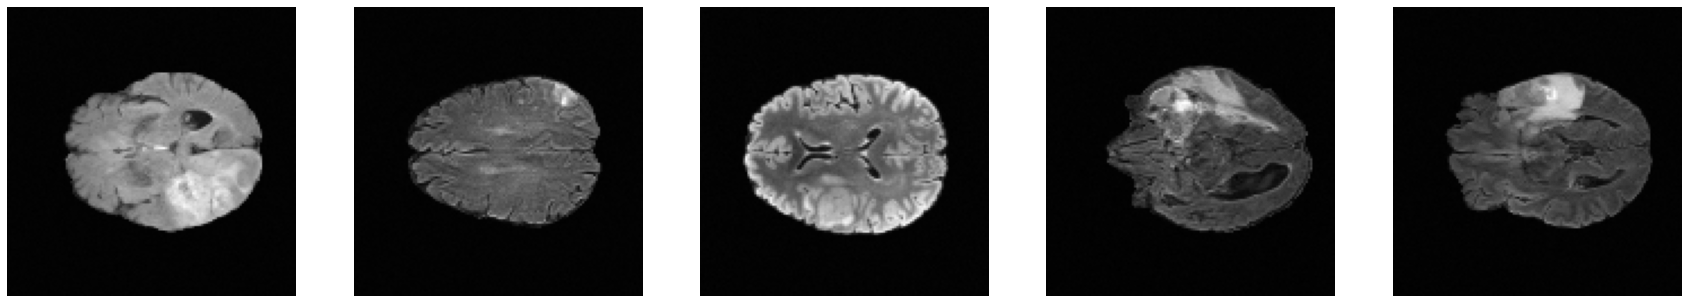

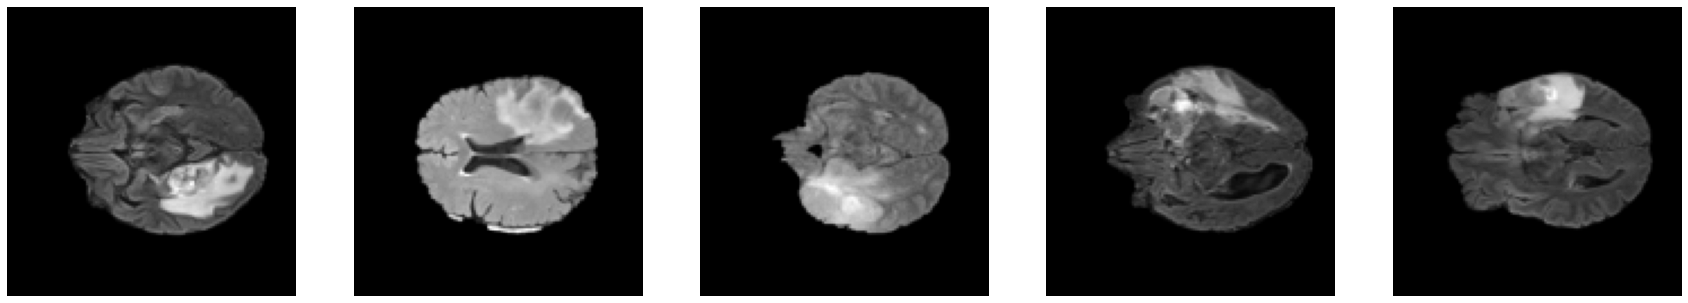

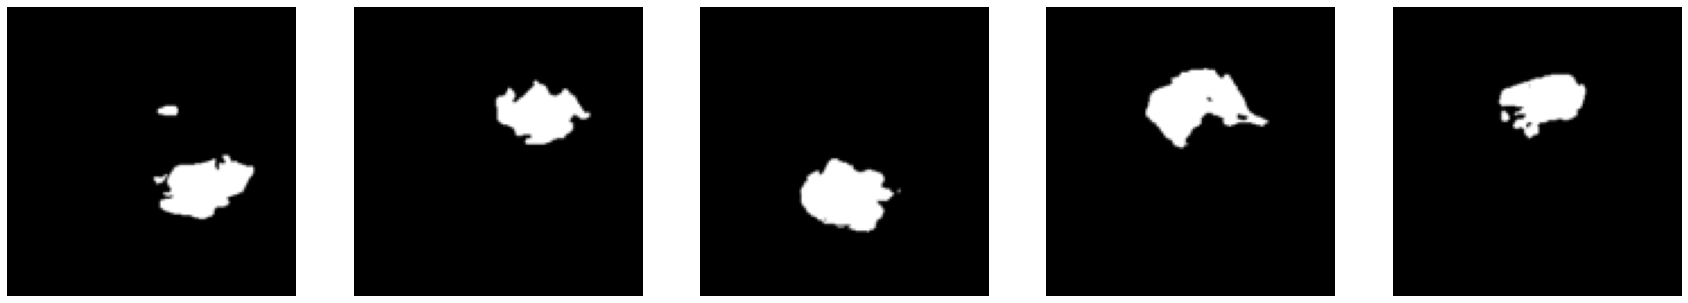

In [25]:
data = np.load('../riemannian_variational_autoencoder/data/brats_data_test.npz')
test_flair, test_masks = data['flair'], data['mask']
test_masks[test_masks > 1] = 1
test_masks = TF.resize(torch.from_numpy(test_masks), (128, 128), antialias=True).type(torch.float32)
test_flair = TF.resize(torch.from_numpy(test_flair), (128, 128), antialias=True)
test_flair = ((test_flair / test_flair.max()) * 2 - 1).type(torch.float32)

n_sample = 5

model.eval()
with torch.no_grad():
    g = diffusion.sample(model=model, x_T=torch.randn(n_sample, IN_CHANNELS, *IMG_SIZE).to(device), condition=test_masks[:n_sample].to(device), w=0.5)

for vec in [g, test_flair, test_masks]:
    plt.figure(figsize=(30, 6))
    for i in range(n_sample):
        plt.subplot(1, n_sample, i + 1)
        plt.imshow(vec[i, 0].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

## Sampling

In [ ]:
n_sample = 10
with torch.no_grad():
    sample = diffusion.sample(model=model, x_T=torch.randn(n_sample, 2, 128, 128).to(device))

for j in range(2):
    plt.figure(figsize=(20, 12))
    for i in range(n_sample):
        plt.subplot(n_sample // 10, 10, i + 1)
        plt.imshow(sample[i, j].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

### Interpolation

In [ ]:
z_a, z_b = torch.randn(2, 1, 2, 128, 128).to(device)
theta = torch.arccos(
    torch.matmul(z_a.view(1, -1), z_b.view(-1, 1)) / (torch.norm(z_a.view(1, -1)) * torch.norm(z_b.view(1, -1)))
).cpu()
steps = 10
latents = []
alphas = torch.sin((1 - torch.arange(0, 10).float() / 10) * theta) / torch.sin(theta)
betas = torch.sin(torch.arange(0, 10).float() / 10 * theta) / torch.sin(theta)
for alpha, beta in zip(alphas[0], betas[0]):
    latents.append(alpha * z_a + beta * z_b)
latents = torch.cat(latents, dim=0)

with torch.no_grad():
    sample = diffusion.sample(model=model, x_T=latents.to(device))

for j in range(2):
    plt.figure(figsize=(20, 12))
    for i in range(n_sample):
        plt.subplot(n_sample // 10, 10, i + 1)
        plt.imshow(sample[i, j].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()